In [16]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pickle import dump
from tqdm import tqdm
from obspy import read
from torchinfo import summary
from utils import *
from autoencoder_model import *

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)




In [17]:
def mkdir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

def save_pkl(obj, save_path):
    """Save a Pyleecan object in a pkl file using cloudpickle

    Parameters
    ----------
    obj: Pyleecan object
        object to save
    save_path: str
        file path
    """

    with open(save_path, "wb") as save_file:
        dump(obj, save_file)

In [2]:
file_path = r"C:\Users\ahmed\Downloads\xb.elyh0.03.vma.2018.334.2.mseed"
try:
    # Attempt to read the file
    stream = read(file_path)
    print("File successfully read!")
    print(stream)
except Exception as e:
    print(f"Error reading file with ObsPy: {e}")
for tr in stream:
    print("\nTrace Statistics:")
    print(f"Network: {tr.stats.network}")
    print(f"Station: {tr.stats.station}")
    print(f"Channel: {tr.stats.channel}")
    print(f"Location: {tr.stats.location}")
    print(f"Start Time: {tr.stats.starttime}")
    print(f"End Time: {tr.stats.endtime}")
    print(f"Sampling Rate: {tr.stats.sampling_rate} Hz")
    print(f"Number of Samples: {tr.stats.npts}")
    print(f"Data Type: {tr.data.dtype}")

    # If needed, you can also access the raw data
    print(f"Data: {tr.data}")

# Print general metadata
print("\nGeneral Metadata:")
print(f"Number of Traces: {len(stream)}")

File successfully read!
1 Trace(s) in Stream:
XB.ELYH0.03.VMA | 2018-11-30T19:05:46.039000Z - 2018-11-30T19:10:42.039000Z | 0.2 Hz, 75 samples

Trace Statistics:
Network: XB
Station: ELYH0
Channel: VMA
Location: 03
Start Time: 2018-11-30T19:05:46.039000Z
End Time: 2018-11-30T19:10:42.039000Z
Sampling Rate: 0.25 Hz
Number of Samples: 75
Data Type: int32
Data: [38016 38016 38016 38017 38020 38017 38018 38016 38019 38018 38016 38019
 38018 38016 38018 38018 38018 38018 38016 38016 38017 38017 38018 38016
 38017 38016 38017 38016 38016 38016 38016 38017 38016 38016 38016 38016
 38016 38017 38016 38016 38016 38017 38016 38016 38016 38016 38016 38016
 38016 38016 38016 38016 38016 38016 38016 38016 38016 38016 38016 38016
 38016 38016 38016 38016 38016 38016 38016 38016 38016 38016 38016 38016
 38016 38016 38016]

General Metadata:
Number of Traces: 1


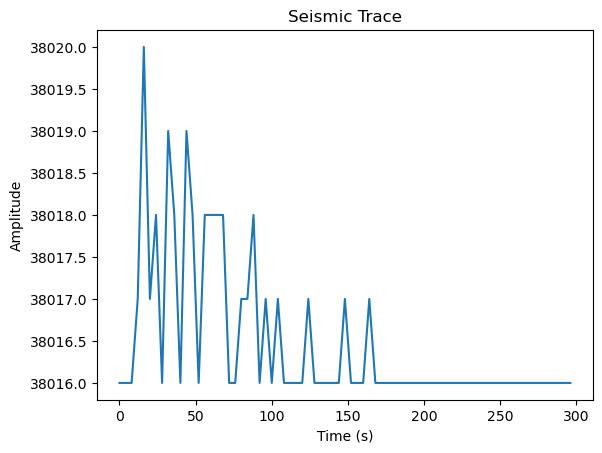

In [3]:
trace = stream[0]
plt.plot(trace.times(), trace.data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Seismic Trace')
plt.show()

In [4]:
# Paths to the folders containing the miniseed files
folder_paths = [
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\334",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\335",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\336",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\337",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\338",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\339",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\340",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\341",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\342",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\343",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\344",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\345",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\346",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\347",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\348",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\349",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\350",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\351",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\352",
    r"C:\Users\ahmed\Downloads\continous_waveform\elyh0\2018\353",
]

# List to hold features for all files (initially empty if not starting fresh)
features_list = []

# Loop over each folder and extract features
for folder_path in folder_paths:
    for filename in os.listdir(folder_path):
        if filename.endswith(".mseed"):
            file_path = os.path.join(folder_path, filename)
            stream = read(file_path)
            
            # Extract features for each trace in the file
            for tr in stream:
                features = extract_features(tr)
                features_list.append(features)

# Convert the list of feature dictionaries into a DataFrame
# If `features_df` already exists, we append the new features to it
'''
if 'features_df' in locals():
    features_df = pd.concat([features_df, pd.DataFrame(features_list)], ignore_index=True)
else:
'''
features_df = pd.DataFrame(features_list)


c:\Users\ahmed\OneDrive\Desktop\Cosmic Analysts\utils.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(data)
c:\Users\ahmed\OneDrive\Desktop\Cosmic Analysts\utils.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(data)


In [5]:
features_df.head(6)

,mean,std,skewness,kurtosis,fft_mean,fft_std,energy
0,38018.520000,2.217266,0.424746,-0.822604,38031.850924,327046.125811,1031407693
1,38016.466667,0.884433,1.951258,3.227789,38022.880827,327029.266165,1019697995
2,32736.413333,2.298367,1.551131,4.123998,32753.860769,281607.247502,-1228921383
3,41354.306667,3.174790,-2.123623,4.688744,41377.488286,355740.502628,-585617133
4,38018.440000,2.275903,0.698776,-0.524344,38032.170993,327045.391132,1030951491
5,38016.426667,0.835437,2.221944,4.786908,38022.381399,327028.975479,1019469890


In [6]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mean      2773 non-null   float64
 1   std       2773 non-null   float64
 2   skewness  2696 non-null   float64
 3   kurtosis  2696 non-null   float64
 4   fft_mean  2773 non-null   float64
 5   fft_std   2773 non-null   float64
 6   energy    2773 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 140.9 KB


In [7]:
features_df.ffill(inplace=True)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mean      2773 non-null   float64
 1   std       2773 non-null   float64
 2   skewness  2773 non-null   float64
 3   kurtosis  2773 non-null   float64
 4   fft_mean  2773 non-null   float64
 5   fft_std   2773 non-null   float64
 6   energy    2773 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 140.9 KB


In [18]:
# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df.values)
X_train, X_temp = train_test_split(X_scaled, test_size=0.15, random_state=seed, shuffle=True)
X_test, X_val = train_test_split(X_temp, test_size=1/3, random_state=seed, shuffle=False)

# Convert the feature data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [48]:
# Initialize the model
model = Autoencoder(X_train_tensor.shape[1])
print(summary(model))
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       512
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       2,080
│    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-5                       2,112
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       455
Total params: 5,159
Trainable params: 5,159
Non-trainable params: 0


In [43]:
def train_autoencoder(model, train_loader, val_loader, num_epochs, num_eval_epoch, patience, 
                      criterion=None, optimizer=None, scheduler=None, save_dir="", gpu_number=0):
    mkdir(save_dir)
    
    if criterion is None:
        criterion = nn.MSELoss()
    
    device = torch.device(f'cuda:{gpu_number}' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model.to(device)
    
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_loss = []
    val_loss = []
    val_reconstruction_errors = []
    val_anomalies_counts = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for _, (inputs, _)  in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = torch.tensor(inputs, dtype=torch.float).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss_epoch = running_loss / len(train_loader)
        train_loss.append(train_loss_epoch)
        
        if scheduler is not None:
            scheduler.step()
        
        if (epoch + 1) % num_eval_epoch == 0:
            result = evaluate_autoencoder(model, val_loader, criterion, device)
            val_loss.append(result["val_loss"])
            val_reconstruction_errors.append(result["val_reconstruction_error"])
            val_anomalies_counts.append(result["val_anomalies_count"])
            
            if result["val_loss"] < best_val_loss:
                best_val_loss = result["val_loss"]
                torch.save({'model_ckpt': model.state_dict(),
                            "optimizer": optimizer.state_dict(),
                            "epoch": epoch,
                            "best_val_loss": best_val_loss,
                            }, os.path.join(save_dir, 'best_val_ckpt.pth'))
                print(f"Best model saved at epoch {epoch + 1}, val loss: {best_val_loss}")
            else:
                patience_counter += 1
                print(f"No improvement in validation loss for {patience_counter} consecutive evaluations.")
            
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    stats = {
        'train_loss': train_loss, 
        'val_loss': val_loss, 
        'val_reconstruction_errors': val_reconstruction_errors,
        'val_anomalies_counts': val_anomalies_counts
    }
    save_pkl(stats, os.path.join(save_dir, 'stats.pkl'))

    return stats



def evaluate_autoencoder(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    reconstruction_errors = []
    
    with torch.no_grad():
        for _, (inputs, _) in tqdm(enumerate(dataloader), total=len(dataloader)):
            inputs = torch.tensor(inputs, dtype=torch.float).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
            reconstruction_error = torch.mean((inputs - outputs) ** 2, dim=1).cpu().numpy()
            reconstruction_errors.extend(reconstruction_error)
    
    val_loss /= len(dataloader)
    threshold = np.percentile(reconstruction_errors, 95)
    anomalies_count = np.sum(np.array(reconstruction_errors) > threshold)
    
    return {
        'val_loss': val_loss, 
        'val_reconstruction_error': reconstruction_errors, 
        'val_anomalies_count': anomalies_count
    }

In [49]:
train_results = train_autoencoder(model, train_dataloader, val_dataloader, num_epochs=50, num_eval_epoch=1, patience=50 ,optimizer=optimizer, scheduler=scheduler, save_dir=r"C:\Users\ahmed\OneDrive\Desktop\Cosmic Analysts\checkpoints")

Using device: cpu


  0%|          | 0/148 [00:00<?, ?it/s]C:\Users\ahmed\AppData\Local\Temp\ipykernel_4016\3622298986.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float).to(device)
  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\ahmed\AppData\Local\Temp\ipykernel_4016\3622298986.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float).to(device)
100%|██████████| 9/9 [00:00<00:00, 923.95it/s]


Best model saved at epoch 1, val loss: 1.1260591348012288


100%|██████████| 9/9 [00:00<00:00, 1286.51it/s]


Best model saved at epoch 2, val loss: 0.9399967922104729


100%|██████████| 9/9 [00:00<00:00, 1092.68it/s]


Best model saved at epoch 3, val loss: 0.6472431454393599


100%|██████████| 9/9 [00:00<00:00, 1125.05it/s]


Best model saved at epoch 4, val loss: 0.45928870638211566


100%|██████████| 9/9 [00:00<00:00, 1078.69it/s]


Best model saved at epoch 5, val loss: 0.30420462704367107


100%|██████████| 9/9 [00:00<00:00, 1169.49it/s]


Best model saved at epoch 6, val loss: 0.2913757777876324


100%|██████████| 9/9 [00:00<00:00, 1067.55it/s]


Best model saved at epoch 7, val loss: 0.2801239631242222


100%|██████████| 9/9 [00:00<00:00, 1134.11it/s]


Best model saved at epoch 8, val loss: 0.26948201490773094


100%|██████████| 9/9 [00:00<00:00, 952.58it/s]


Best model saved at epoch 9, val loss: 0.2594010565016005


100%|██████████| 9/9 [00:00<00:00, 1126.29it/s]


Best model saved at epoch 10, val loss: 0.25020216157039005


100%|██████████| 9/9 [00:00<00:00, 988.91it/s]


Best model saved at epoch 11, val loss: 0.24926458878649604


100%|██████████| 9/9 [00:00<00:00, 1125.72it/s]


Best model saved at epoch 12, val loss: 0.24837120125691095


100%|██████████| 9/9 [00:00<00:00, 1079.77it/s]


Best model saved at epoch 13, val loss: 0.24747158918115827


100%|██████████| 9/9 [00:00<00:00, 1286.33it/s]


Best model saved at epoch 14, val loss: 0.2465453123052915


100%|██████████| 9/9 [00:00<00:00, 1122.07it/s]


Best model saved at epoch 15, val loss: 0.24565798623694313


100%|██████████| 9/9 [00:00<00:00, 1125.69it/s]


Best model saved at epoch 16, val loss: 0.24556908342573378


100%|██████████| 9/9 [00:00<00:00, 1207.53it/s]


Best model saved at epoch 17, val loss: 0.24548020876116222


100%|██████████| 9/9 [00:00<00:00, 1094.45it/s]


Best model saved at epoch 18, val loss: 0.2453881013724539


100%|██████████| 9/9 [00:00<00:00, 1125.35it/s]


Best model saved at epoch 19, val loss: 0.24530212001668084


100%|██████████| 9/9 [00:00<00:00, 1123.57it/s]


Best model saved at epoch 20, val loss: 0.24521104908651775


100%|██████████| 9/9 [00:00<00:00, 1125.38it/s]


Best model saved at epoch 21, val loss: 0.2452044983704885


100%|██████████| 9/9 [00:00<00:00, 1147.83it/s]


Best model saved at epoch 22, val loss: 0.24519766122102737


100%|██████████| 9/9 [00:00<00:00, 1106.16it/s]


Best model saved at epoch 23, val loss: 0.24519086049662697


100%|██████████| 9/9 [00:00<00:00, 1286.68it/s]


Best model saved at epoch 24, val loss: 0.24518410116434097


100%|██████████| 9/9 [00:00<00:00, 1200.54it/s]


Best model saved at epoch 25, val loss: 0.24517728719446394


100%|██████████| 9/9 [00:00<00:00, 1125.99it/s]


Best model saved at epoch 26, val loss: 0.24517722427845


100%|██████████| 9/9 [00:00<00:00, 1120.01it/s]


Best model saved at epoch 27, val loss: 0.2451771448055903


100%|██████████| 9/9 [00:00<00:00, 1286.51it/s]


Best model saved at epoch 28, val loss: 0.24517706781625748


100%|██████████| 9/9 [00:00<00:00, 1286.73it/s]


Best model saved at epoch 29, val loss: 0.2451770065559281


100%|██████████| 9/9 [00:00<00:00, 1270.19it/s]


Best model saved at epoch 30, val loss: 0.24517693453364903


100%|██████████| 9/9 [00:00<00:00, 1106.58it/s]


Best model saved at epoch 31, val loss: 0.2451769295665953


100%|██████████| 9/9 [00:00<00:00, 1286.90it/s]


Best model saved at epoch 32, val loss: 0.24517692791091072


100%|██████████| 9/9 [00:00<00:00, 1286.68it/s]


No improvement in validation loss for 1 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1024.08it/s]


No improvement in validation loss for 2 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1285.72it/s]


No improvement in validation loss for 3 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1070.31it/s]


No improvement in validation loss for 4 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1286.55it/s]


No improvement in validation loss for 5 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1087.23it/s]


No improvement in validation loss for 6 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1175.68it/s]


No improvement in validation loss for 7 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1286.77it/s]


No improvement in validation loss for 8 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1044.23it/s]


No improvement in validation loss for 9 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1125.52it/s]


No improvement in validation loss for 10 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1009.92it/s]


No improvement in validation loss for 11 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 947.34it/s]


No improvement in validation loss for 12 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1084.39it/s]


No improvement in validation loss for 13 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1286.38it/s]


No improvement in validation loss for 14 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1077.52it/s]


No improvement in validation loss for 15 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1144.94it/s]


No improvement in validation loss for 16 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1285.72it/s]


No improvement in validation loss for 17 consecutive evaluations.


100%|██████████| 9/9 [00:00<00:00, 1045.09it/s]

No improvement in validation loss for 18 consecutive evaluations.


In [50]:
test_results = evaluate_autoencoder(model, test_dataloader,criterion=nn.MSELoss(), device='cpu')
test_reconstruction_errors = test_results["val_reconstruction_error"]

  0%|          | 0/18 [00:00<?, ?it/s]C:\Users\ahmed\AppData\Local\Temp\ipykernel_4016\3622298986.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float).to(device)
100%|██████████| 18/18 [00:00<00:00, 901.46it/s]


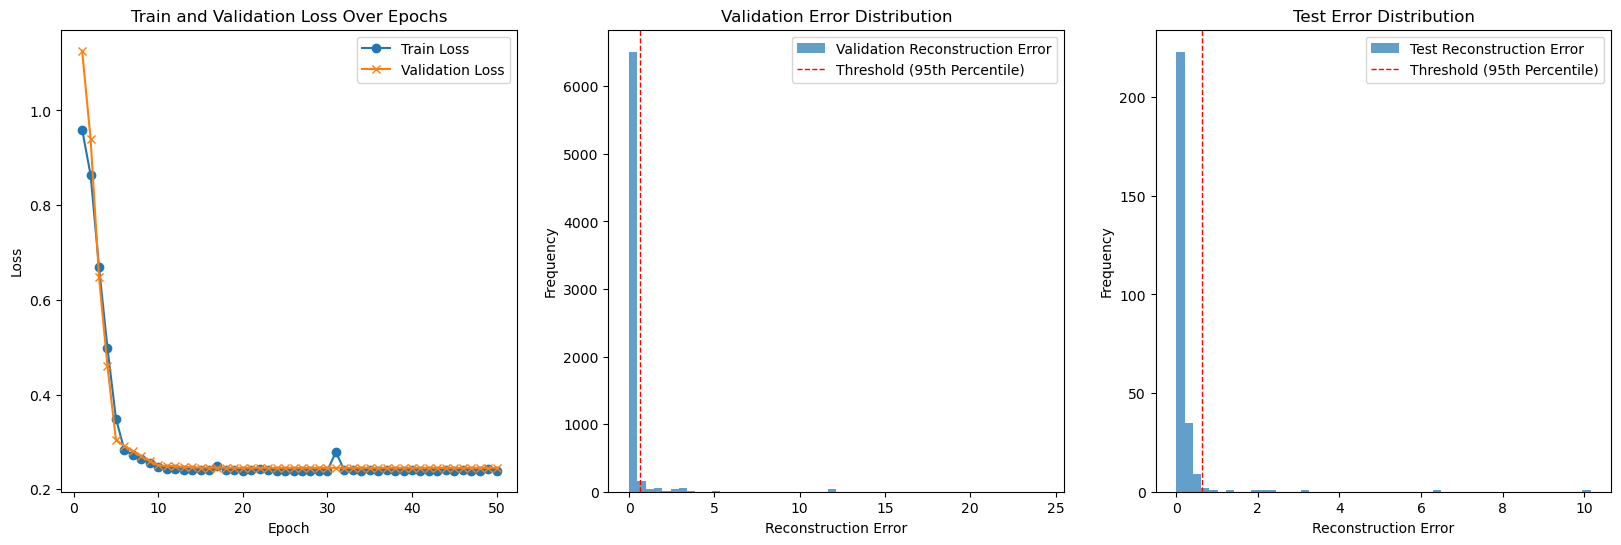

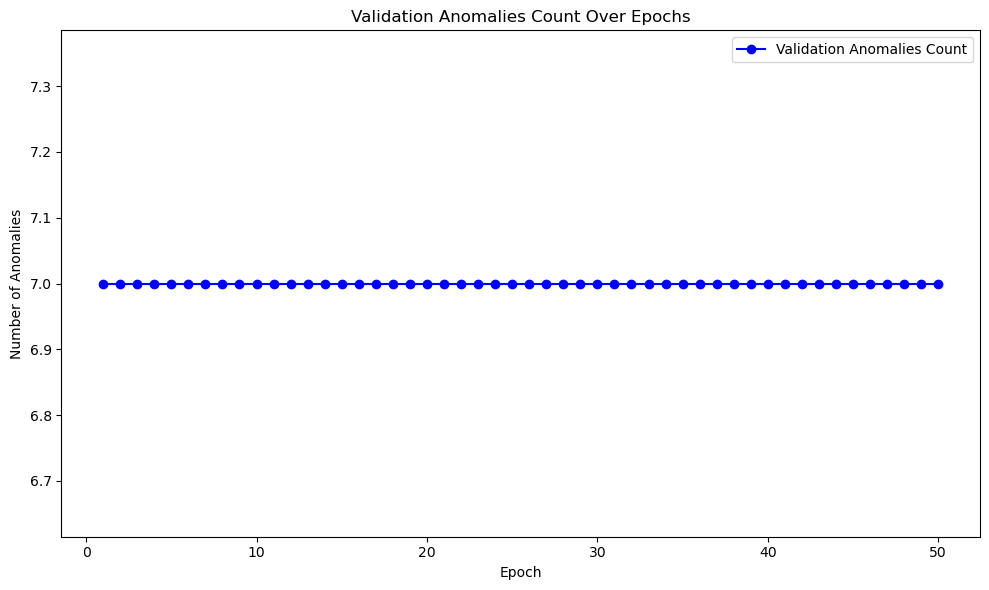

In [52]:
# Plot loss over epochs
plt.figure(figsize=(20, 6))

# Plot training and validation loss over epochs
plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_results["train_loss"]) + 1)
plt.plot(epochs_range, train_results["train_loss"], label='Train Loss', marker='o')
plt.plot(epochs_range, train_results["val_loss"], label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()

# Plot validation reconstruction error with threshold
plt.subplot(1, 3, 2)
val_reconstruction_errors_flat = [item for sublist in train_results["val_reconstruction_errors"] for item in sublist]
threshold = np.percentile(val_reconstruction_errors_flat, 95)  

plt.hist(val_reconstruction_errors_flat, bins=50, alpha=0.7, label='Validation Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label='Threshold (95th Percentile)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Validation Error Distribution')
plt.legend()

# Plot test reconstruction error with threshold
plt.subplot(1, 3, 3)
plt.hist(test_reconstruction_errors, bins=50, alpha=0.7, label='Test Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label='Threshold (95th Percentile)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Test Error Distribution')
plt.legend()

# Plot validation anomalies count over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_results["val_anomalies_counts"]) + 1), train_results["val_anomalies_counts"], marker='o', color='b', label='Validation Anomalies Count')
plt.xlabel('Epoch')
plt.ylabel('Number of Anomalies')
plt.title('Validation Anomalies Count Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
print(train_results["val_anomalies_counts"])

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [55]:
test_results["val_anomalies_count"]

14